Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


780/780 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 0.0016 - val_loss: 9.3657e-05 - learning_rate: 0.0010
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - loss: 1.4705e-04 - val_loss: 9.2520e-05 - learning_rate: 0.0010
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - loss: 1.0851e-04 - val_loss: 8.8799e-05 - learning_rate: 0.0010
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - loss: 1.2401e-04 - val_loss: 7.9627e-05 - learning_rate: 0.0010
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - loss: 9.7908e-05 - val_loss: 6.4761e-05 - learning_rate: 0.0010
Epoch 6/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - loss: 1.1867e-04 - val_loss: 5.6110e-05 - learning_rate: 0.0010
Epoch 7/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - loss: 1.0049e-04 - val_loss: 5.7946e-05 - learning_rate: 2.0000e-04
Epoch 8/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - loss: 6.9899e-05 - val_loss: 5.8042e-05 - learning_rate: 2.0000e-04
Epoch 9/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 59m

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


780/780 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step - loss: 0.0029 - val_loss: 1.0142e-04 - learning_rate: 0.0010
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - loss: 1.5529e-04 - val_loss: 8.5697e-05 - learning_rate: 0.0010
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - loss: 1.7055e-04 - val_loss: 8.2625e-05 - learning_rate: 0.0010
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - loss: 1.5080e-04 - val_loss: 8.0771e-05 - learning_rate: 0.0010
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - loss: 1.2275e-04 - val_loss: 7.5736e-05 - learning_rate: 0.0010
Epoch 6/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - loss: 1.1598e-04 - val_loss: 6.9495e-05 - learning_rate: 0.0010
Epoch 7/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - loss: 9.2238e-05 - val_loss: 6.6479e-05 - learning_rate: 2.0000e-04
Epoch 8/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - loss: 1.1331e-04 - val_loss: 6.1690e-05 - learning_rate: 2.0000e-04
Epoch 9/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 59m

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


780/780 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 0.0018 - val_loss: 9.4636e-05 - learning_rate: 0.0010
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - loss: 1.2982e-04 - val_loss: 8.8138e-05 - learning_rate: 0.0010
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - loss: 1.0341e-04 - val_loss: 8.5116e-05 - learning_rate: 0.0010
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - loss: 1.0539e-04 - val_loss: 7.9987e-05 - learning_rate: 0.0010
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 46s 59ms/step - loss: 8.4309e-05 - val_loss: 7.0490e-05 - learning_rate: 0.0010
Epoch 6/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - loss: 9.8390e-05 - val_loss: 6.1486e-05 - learning_rate: 0.0010
Epoch 7/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - loss: 7.6208e-05 - val_loss: 5.8962e-05 - learning_rate: 2.0000e-04
Epoch 8/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 51s 66ms/step - loss: 6.6228e-05 - val_loss: 6.0783e-05 - learning_rate: 2.0000e-04
Epoch 9/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 47s 60m

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


780/780 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 0.0025 - val_loss: 1.7707e-04 - learning_rate: 0.0010
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 64s 83ms/step - loss: 1.6696e-04 - val_loss: 9.5715e-05 - learning_rate: 0.0010
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - loss: 1.2747e-04 - val_loss: 8.7466e-05 - learning_rate: 0.0010
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - loss: 1.2237e-04 - val_loss: 8.2211e-05 - learning_rate: 0.0010
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - loss: 1.6156e-04 - val_loss: 7.0715e-05 - learning_rate: 0.0010
Epoch 6/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 56s 72ms/step - loss: 1.3482e-04 - val_loss: 7.2054e-05 - learning_rate: 0.0010
Epoch 7/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - loss: 9.6343e-05 - val_loss: 6.2786e-05 - learning_rate: 0.0010
Epoch 8/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - loss: 1.2763e-04 - val_loss: 5.5321e-05 - learning_rate: 0.0010
Epoch 9/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step -

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


780/780 ━━━━━━━━━━━━━━━━━━━━ 65s 80ms/step - loss: 0.0017 - val_loss: 1.4609e-04 - learning_rate: 0.0010
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - loss: 1.9200e-04 - val_loss: 1.1158e-04 - learning_rate: 0.0010
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - loss: 1.1904e-04 - val_loss: 8.9284e-05 - learning_rate: 0.0010
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - loss: 1.4732e-04 - val_loss: 1.0657e-04 - learning_rate: 0.0010
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 61s 78ms/step - loss: 9.4101e-05 - val_loss: 8.9210e-05 - learning_rate: 0.0010
Epoch 6/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - loss: 9.8443e-05 - val_loss: 7.6723e-05 - learning_rate: 0.0010
Epoch 7/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 60s 77ms/step - loss: 9.3354e-05 - val_loss: 5.9676e-05 - learning_rate: 2.0000e-04
Epoch 8/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - loss: 9.8144e-05 - val_loss: 5.9585e-05 - learning_rate: 2.0000e-04
Epoch 9/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 54s 69m

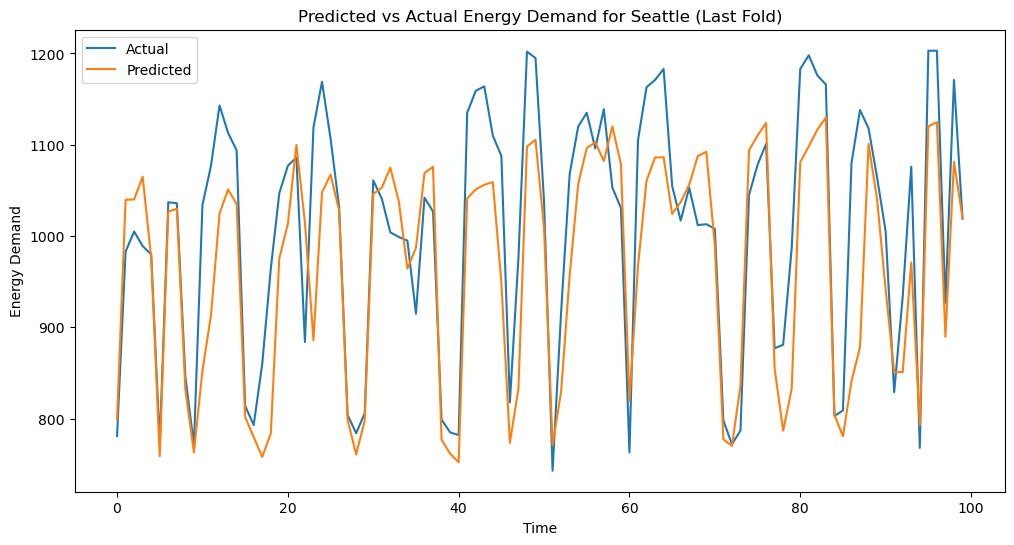

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_excel('../City-Specific Data/Seattle.xlsx')
df = df.dropna()

features = df[['Temperature', 'DewPoint', 'RelativeHumidity', 'Precipitation', 'WindSpeed', 'Pressure']].values
energy_demand = df['EnergyDemand'].values.reshape(-1, 1)

scaler_features = MinMaxScaler()
scaler_energy = MinMaxScaler()
features_normalized = scaler_features.fit_transform(features)
energy_demand_normalized = scaler_energy.fit_transform(energy_demand)

def create_sequences(features, targets, seq_length):
    feature_sequences = []
    target_sequences = []
    for i in range(len(features) - seq_length):
        feature_seq = features[i:i+seq_length]
        target_seq = targets[i+seq_length]
        feature_sequences.append(feature_seq)
        target_sequences.append(target_seq)
    return np.array(feature_sequences), np.array(target_sequences)

seq_length = 48
X, y = create_sequences(features_normalized, energy_demand_normalized, seq_length)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = Sequential([
        GRU(100, activation='tanh', return_sequences=True, input_shape=(seq_length, X.shape[2])),
        Dropout(0.2),
        GRU(50, activation='tanh'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    loss = model.evaluate(X_test, y_test)
    predictions_normalized = model.predict(X_test)
    predictions = scaler_energy.inverse_transform(predictions_normalized)
    y_test_original = scaler_energy.inverse_transform(y_test)

    mse = mean_squared_error(y_test_original, predictions)
    mae = mean_absolute_error(y_test_original, predictions)
    mse_scores.append(mse)
    mae_scores.append(mae)

average_mse = np.mean(mse_scores)
average_mae = np.mean(mae_scores)
print(f"Average Mean Squared Error: {average_mse}")
print(f"Average Mean Absolute Error: {average_mae}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.title('Predicted vs Actual Energy Demand for Seattle (Last Fold)')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()

In [8]:
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
result = calculate_mape(y_test_original, predictions)
print(result)

7.080924725748723
